In [15]:
import cv2
import numpy as np
from scipy.cluster.hierarchy import fclusterdata
import matplotlib.pyplot as plt

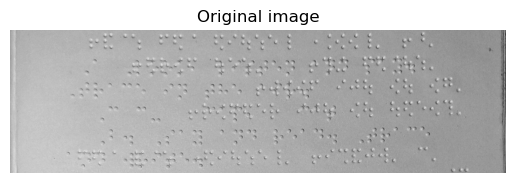

In [16]:
image = cv2.imread("b9.jpg", cv2.IMREAD_GRAYSCALE)

output_image = image.copy()
output_image2 = image.copy()

h,w = image.shape

if w > 500:
    new_w = 500
    ar = w/h
    new_h = int(new_w/ar)

    img = cv2.resize(image,(new_w,new_h),interpolation=cv2.INTER_AREA)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Original image")
plt.axis('off')
plt.show()

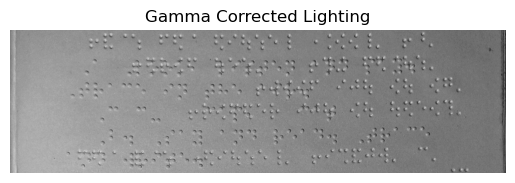

In [17]:
#gama correction 
def gamma_correction(image, gamma=2.5):
    normalized = image / 255.0
    corrected = np.power(normalized, gamma)
    
    return (corrected * 255).astype(np.uint8)

corrected_image = gamma_correction(image, gamma=3)

plt.imshow(corrected_image, cmap='gray')
plt.axis('off')
plt.title("Gamma Corrected Lighting")
plt.show()


In [18]:
def dilation(image, kernel_size=(3, 3), iterations=1):
    
    kernel = np.ones(kernel_size, np.uint8)
    dilated_image = cv2.dilate(image, kernel, iterations=iterations)
    dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_CLOSE, kernel)   
    return dilated_image

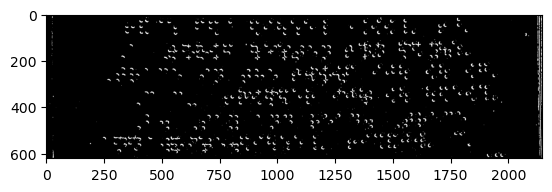

In [19]:
def thresholding(image):
    blur = cv2.GaussianBlur(image, (7, 7), 0)
    thresh = cv2.adaptiveThreshold(
        blur,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15,
        3
    )
    return thresh
thresh_img = thresholding(corrected_image);

plt.imshow(thresh_img, cmap='gray')
plt.show()

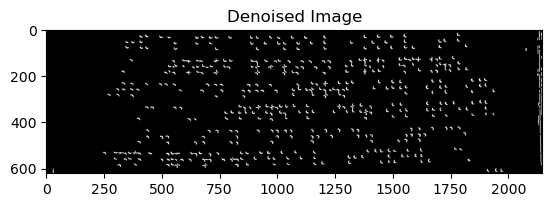

In [20]:
def remove_noise(image, kernel_size=3, min_size=50):

    # Morphological operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    denoised = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    # remove small regions
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(denoised, connectivity=8)
    output = np.zeros_like(denoised)

    for i in range(1, num_labels):  # Skip the background (label 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            output[labels == i] = 255

    return output

# Example Usage
denoised_image = remove_noise(thresh_img, kernel_size=3, min_size=30)

# Display the results
plt.imshow(denoised_image, cmap='gray')
plt.title("Denoised Image")
plt.show()


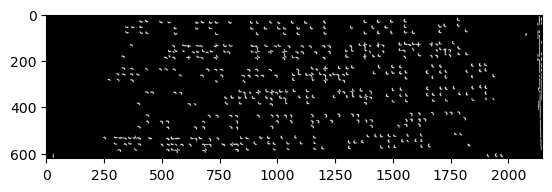

In [21]:
def sharping(image):
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    sharp = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

    return sharp
sharp_image=sharping(denoised_image)
# Display the result
plt.imshow(sharp_image,cmap='gray')

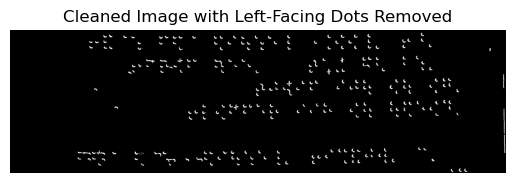

In [22]:
def remove_left_facing_dots(image, intensity_ratio_threshold=1.2):

    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    
    edges = cv2.Canny(blurred, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        roi = image[y:y+h, x:x+w]
        left_half = roi[:, :w//2].sum()
        right_half = roi[:, w//2:].sum()

        if right_half < left_half * intensity_ratio_threshold:
            filtered_contours.append(contour)

    
    mask = np.zeros_like(image)
    cv2.drawContours(mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

    cleaned_image = cv2.bitwise_and(image, mask)

    return cleaned_image

cleaned_image = remove_left_facing_dots(sharp_image, intensity_ratio_threshold=1.3)

plt.imshow(cleaned_image, cmap='gray')
plt.title("Cleaned Image with Left-Facing Dots Removed")
plt.axis('off')
plt.show()


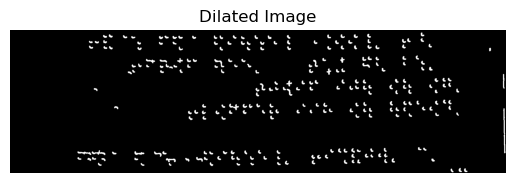

In [23]:
dilated_image = dilation(cleaned_image, kernel_size=(3, 3), iterations=1)

# Display the result
plt.imshow(dilated_image, cmap='gray')
plt.title('Dilated Image')
plt.axis('off')
plt.show()


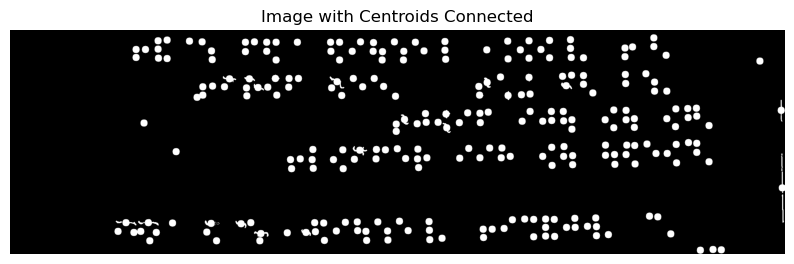

In [24]:
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append((cX, cY))

# Add dots (circles) at each centroid and connect them with lines
for i, (cX, cY) in enumerate(centroids):
    # Draw circle at each centroid
    cv2.circle(output_image2, (cX, cY), 5, (0, 0, 255), -1) 
    cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)
    cv2.circle(cleaned_image,(cX,cY),10,(255,0,255),-1)
    

# Display the image with centroids marked and connected

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(cleaned_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image with Centroids Connected")
plt.show()



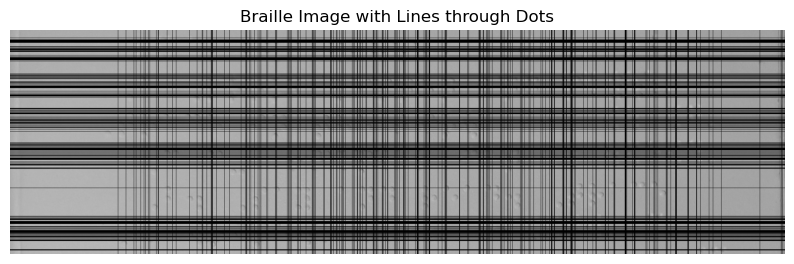

In [25]:
for cX, cY in centroids:
    # Draw horizontal line passing through the dot
    cv2.line(output_image, (0, cY), (output_image.shape[1], cY), (0, 255, 0), 1)
    # Draw vertical line passing through the dot
    cv2.line(output_image, (cX, 0), (cX, output_image.shape[0]), (0, 255, 0), 1)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Braille Image with Lines through Dots")
plt.show()

600.0308325411287
Minimum distance between centroid (1784, 24) and centroid (1784, 48) is: 24.0


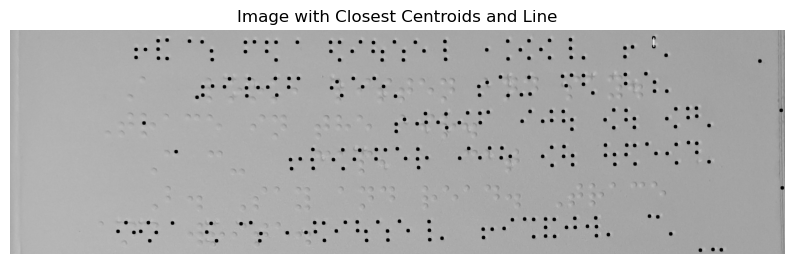

In [26]:
import math 

sorted_centroids = sorted(centroids, key=lambda c: (c[1], c[0]))
c1 = sorted_centroids[0]    
distance = 1000  # Initialize with a large value
closest_c2 = None  # To store the second centroid of the closest pair
largest_distance = 0  # This will sum all the distances
num_distances = 0
for i in range(len(centroids) - 1):  
    c2 = sorted_centroids[i + 1]  # Neighboring centroid
    
    # Calculate the Euclidean distance between the two centroids
    dis = math.sqrt((c2[0] - c1[0])**2 + (c2[1] - c1[1])**2)
    
    
    # Update the minimum distance and the closest pair of centroids
    if dis < distance:
        distance = dis
        closest_c2 = c2 
    else:
        largest_distance = dis
    num_distances+=1
 

print(largest_distance)
print(f"Minimum distance between centroid {c1} and centroid {closest_c2} is: {distance}")

# Draw a line between the two closest centroids
cv2.line(output_image2, c1, closest_c2, (255, 255, 200), 2)  # Green line between c1 and closest_c2

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image with Closest Centroids and Line")
plt.show()

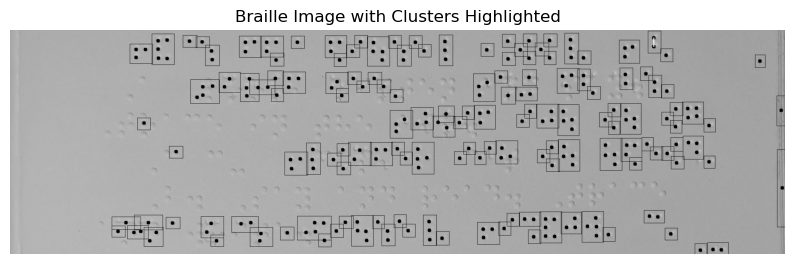

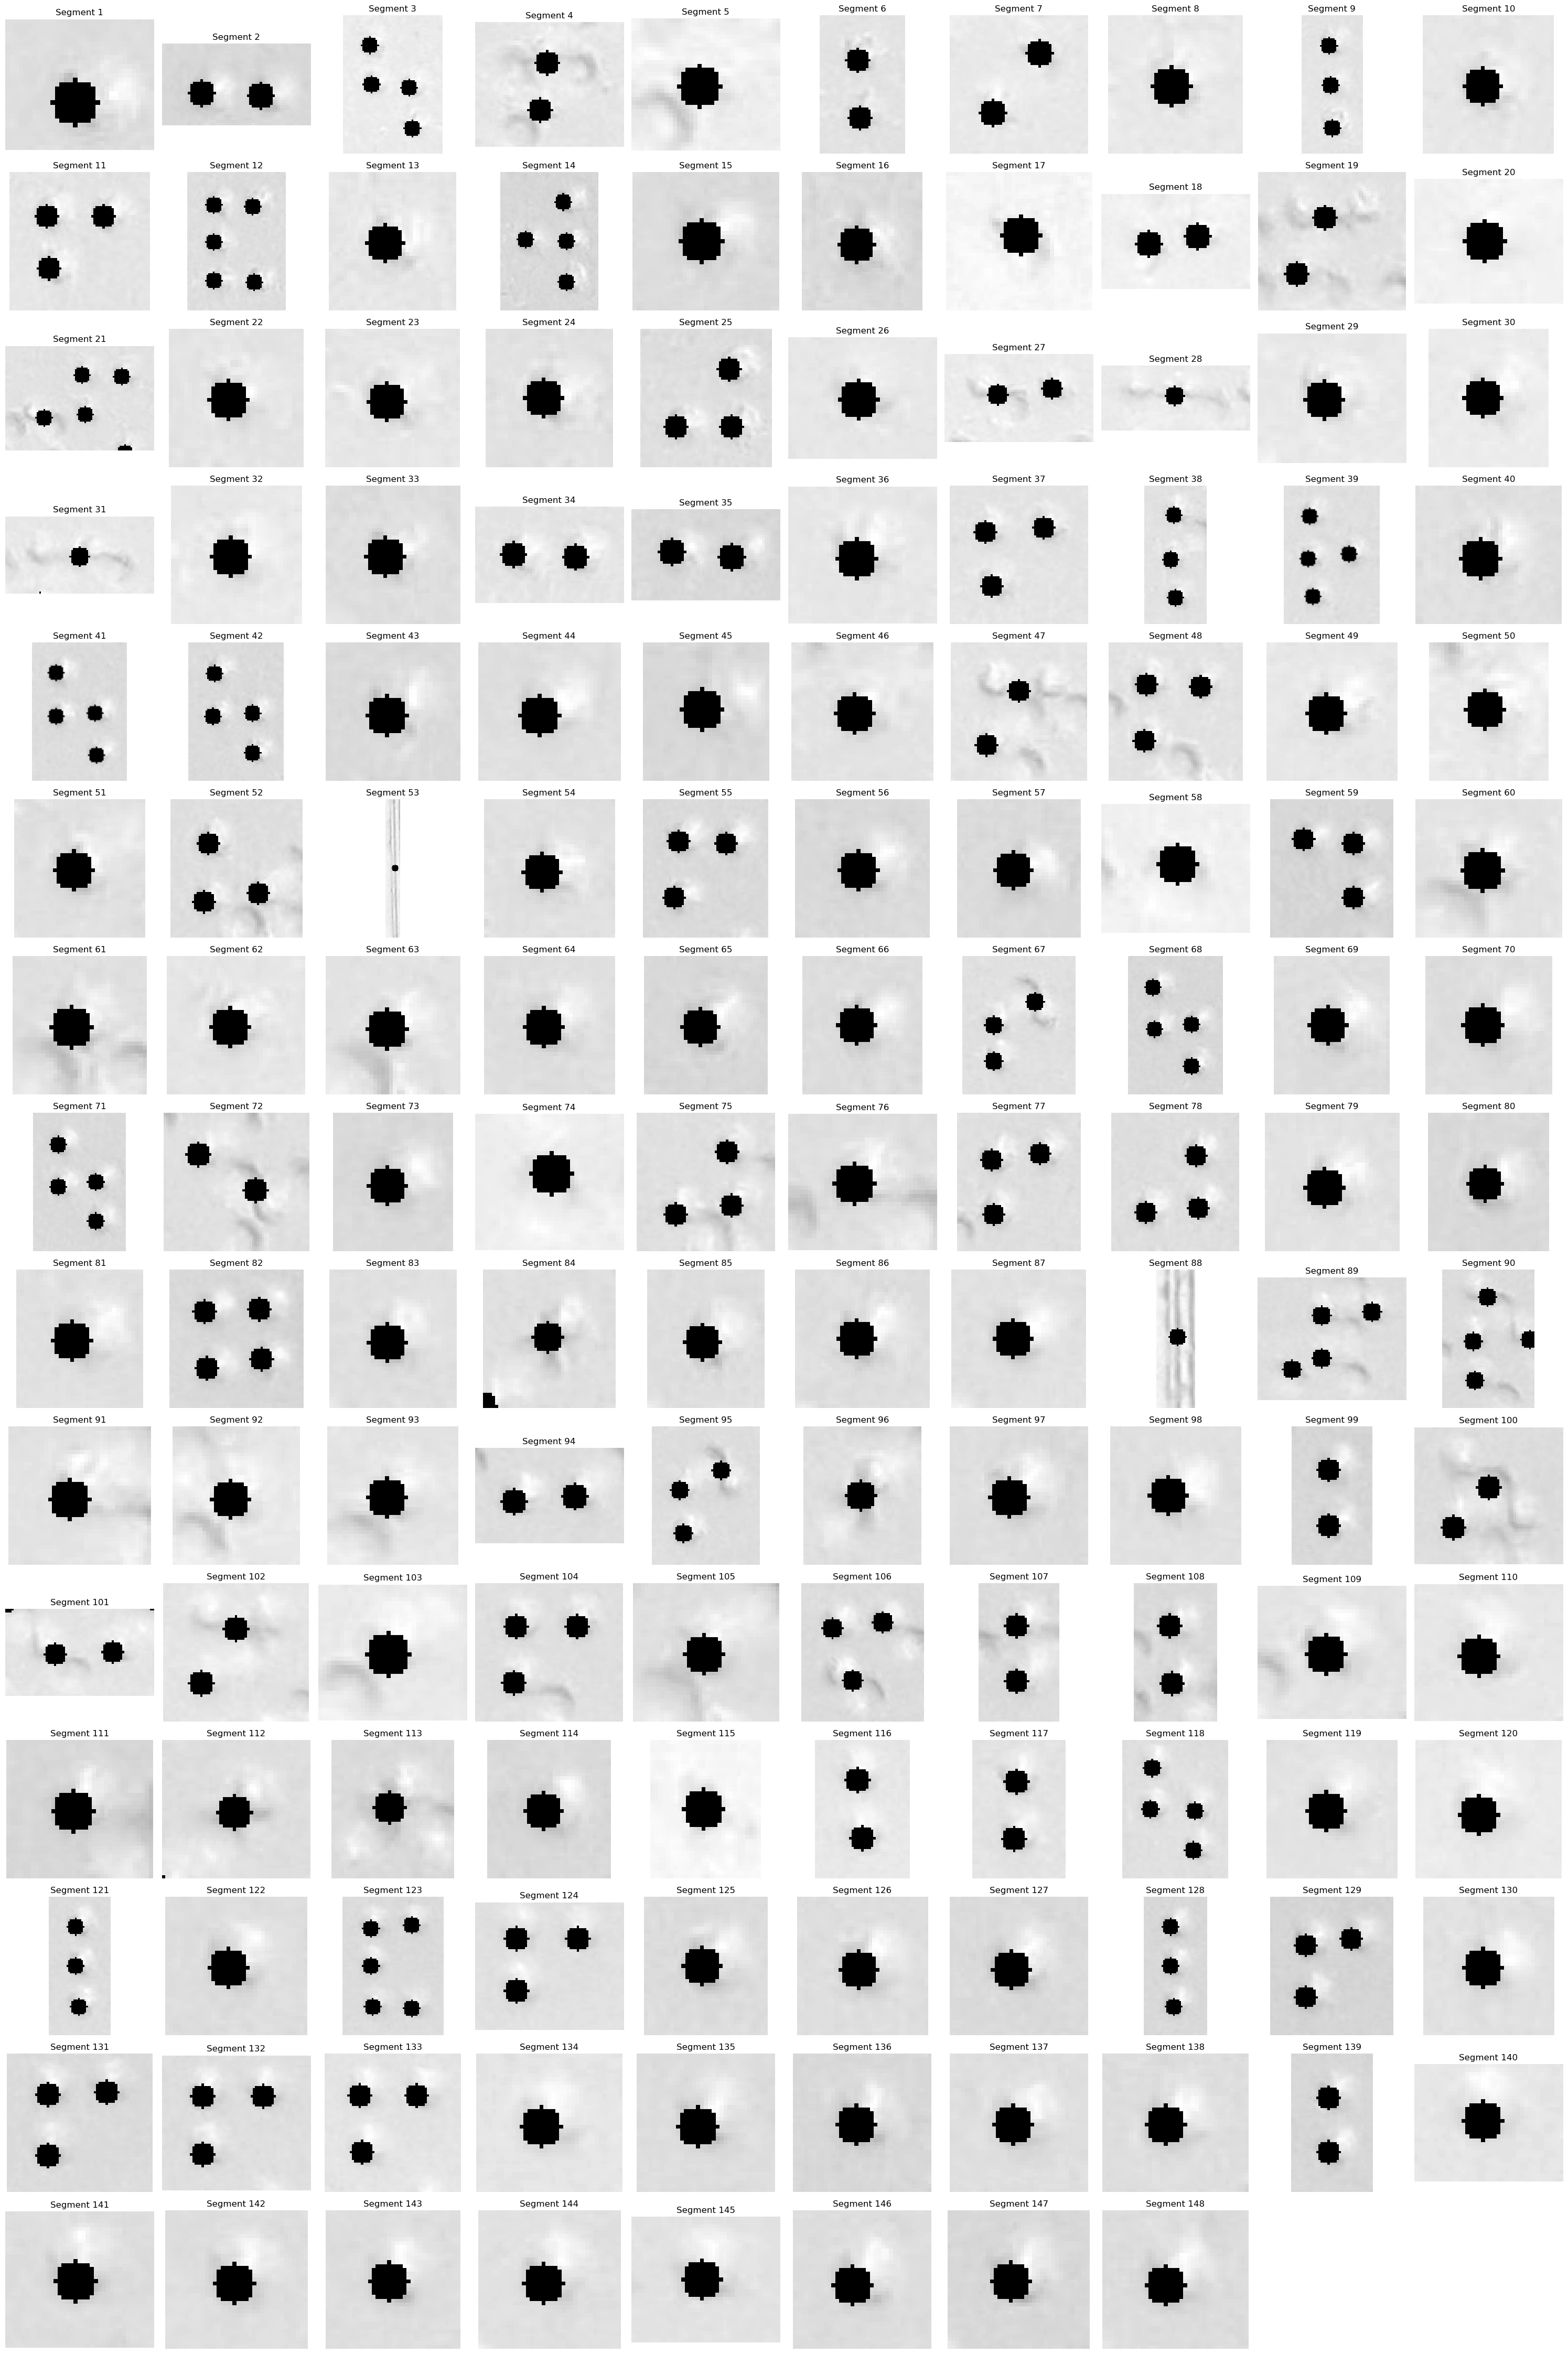

In [27]:

distance_threshold = 30 #i wanted to make it dynamic , using the distnce 
labels = fclusterdata(np.array(centroids), t=distance_threshold, criterion="distance")


clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(contours[i])
    


segments = []
margin = 10

for cluster_contours in clusters.values():
    # Get bounding box
    x_min = min([cv2.boundingRect(c)[0] for c in cluster_contours]) - margin
    y_min = min([cv2.boundingRect(c)[1] for c in cluster_contours]) - margin
    x_max = max([cv2.boundingRect(c)[0] + cv2.boundingRect(c)[2] for c in cluster_contours]) + margin
    y_max = max([cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3] for c in cluster_contours]) + margin

    # Crop the image around the bounding box
    segment = image[y_min:y_max, x_min:x_max]
    segments.append(segment)
    
    # Draw rectangle around the cluster
    cv2.rectangle(output_image2, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Braille Image with Clusters Highlighted")
plt.show()


num_segments = len(segments)
images_per_row = 10
# Calculate the number of rows required
num_rows = (num_segments // images_per_row) + (num_segments % images_per_row != 0)
# Create a figure
plt.figure(figsize=(3 * images_per_row, 3 * num_rows))

# Plot each segment
for i, segment in enumerate(segments):

    row = i // images_per_row  
    col = i % images_per_row
    plt.subplot(num_rows, images_per_row, i + 1)
    plt.imshow(segment, cmap='gray')
    plt.axis('off')
    plt.title(f'Segment {i+1}')

# Adjust layout and show the images
plt.tight_layout()
plt.show()